In [4]:
import numpy as np
# import fractions
# np.set_printoptions(formatter={'all':lambda x: str(fractions.Fraction(x).limit_denominator())})

In [108]:
def find_basis_vector(basis, A, b, log=False):
    def _print(*s):
        if log: print(s)
    indices = np.arange(A.shape[1], dtype=int)
    _print(f'   Finding basis vector for basis: {basis}')

    # let B be the submatrix of A with
    # columns indexed by the basis
    B = A[:, basis]
    _print('   B is')
    _print(B)

    # make sure B is full rank
    assert B.shape[0] == np.linalg.matrix_rank(B)

    B_inv = np.linalg.inv(B)
    _print('   B_inv is')
    _print(B_inv)

    x = B_inv @ b
    x = np.array([(x[basis.index(i)] if i in basis else 0) for i in indices])
    _print(f'   Corresponding basis vector is: {x}')
    if (x >= 0).all():
        _print('   The basis vector is feasible!')
    return x

def _list_complement(part, whole):
    return [i for i in whole if i not in part]

def run_simplex(c, A, b, starting_basis, pricing, log=False, max_iter=200):
    def _print(*s):
        if log: print(s)
    basis = starting_basis
    # Store all indices of cols in A
    indices = np.arange(A.shape[1], dtype=int)
    non_basis = _list_complement(basis, indices)
    x = find_basis_vector(basis, A, b)

    k = -1
    while True:
        if k > max_iter:
            _print(' Stopping. Too many iterations.')
            return None, None, None, None
        k += 1
        _print(f'Simplex: Begin iteration {k}')

        c_N = [c[i] for i in non_basis]
        c_B = [c[i] for i in basis]
        A_N = A[:, non_basis]
        A_B = A[:, basis]

        _print(A_B)

        c_tilde_N = c_N - A_N.T @ np.linalg.inv(A_B).T @ c_B
        _print(c_tilde_N)

        if (c_tilde_N >= 0).all():
            _print(f' Solution obtained: {x} for basis {basis}')
            return basis, x, k, c.T@x

        min_c_tilde_N = np.min(c_tilde_N)

        if pricing == 0:
            # Find the first index r such taht
            # it is of the min element in c
            r = non_basis[np.where(c_tilde_N == min_c_tilde_N)[0][0]]
        else:
            r = non_basis[np.where(c_tilde_N < 0)[0][0]]

        _print(f' Chose r={r} (pricing ={pricing}{", used Bland" if pricing == 1 else ""}).')

        d = np.linalg.inv(A_B) @ A[:, r]
        _print(f' Calculated d={d}')

        if (d <= 0).all():
            print(' Problem is unbounded!')
            return None, None, None, None

        ratios = [x[i] / d[basis.index(i)] if d[basis.index(i)] > 0 else np.inf for i in basis]
        _print(ratios)
        t = np.min([j for j in ratios if j >= 0])
        s = basis[ratios.index(t)]
        _print(f't = {t}, chose s={s}')

        x = [x[i] - t * d[basis.index(i)] if i in basis and i != s else (t if r == i else 0) for i in indices]
        basis = [i for i in (*basis, r) if i != s]
        non_basis = _list_complement(basis, indices)

        _print(' Iteration yields:')
        _print(f'  x_{k+1} = {x}')
        _print(f'  B_{k+1} = {basis}')
        _print(f'  N_{k+1} = {non_basis}')

In [109]:
# TEST: Lecture example for Simplex
c = np.array([-2,-3,-4,0,0,0,0])
# define A: matrix with rows (1, -2, 4, -1), (2, 3, 1, 2)
A = np.array([[1,1,1,1,0,0,0], [0,3,1,0,1,0,0], [1,0,0,0,0,1,0], [0,0,1,0,0,0,1]])
b = np.array([4,6,2,3])

rank_A = np.linalg.matrix_rank(A)
print(f'Rank A: {rank_A}')
assert rank_A >= A.shape[0]
print(c)
print(A)
print(b)

Rank A: 4
[-2 -3 -4  0  0  0  0]
[[1 1 1 1 0 0 0]
 [0 3 1 0 1 0 0]
 [1 0 0 0 0 1 0]
 [0 0 1 0 0 0 1]]
[4 6 2 3]


In [110]:
run_simplex(c, A, b, [0, 3, 4, 6], 1)

([4, np.int32(2), np.int32(5), np.int32(1)],
 [0, np.float64(1.0), np.float64(3.0), 0, np.float64(0.0), np.float64(2.0), 0],
 4,
 np.float64(-15.0))

In [111]:
run_simplex(c, A, b, [0, 3, 4, 6], 0)

([4, np.int32(2), np.int32(5), np.int32(1)],
 [0, np.float64(1.0), np.float64(3.0), 0, np.float64(0.0), np.float64(2.0), 0],
 3,
 np.float64(-15.0))

In [112]:
# TEST: Ex 14
c = np.array([3,1,0,0])
# define A: matrix with rows (1, -2, 4, -1), (2, 3, 1, 2)
A = np.array([[1,-1,1,0], [1,-3,0,1]])
b = np.array([3,1])

rank_A = np.linalg.matrix_rank(A)
print(f'Rank A: {rank_A}')
assert rank_A >= A.shape[0]
print(c)
print(A)
print(b)
basis, x, _, _ = run_simplex(c, A, b, [0,1], 1)
basis, x

Rank A: 2
[3 1 0 0]
[[ 1 -1  1  0]
 [ 1 -3  0  1]]
[3 1]


([np.int32(2), np.int32(3)], [0, 0, np.float64(3.0), np.float64(1.0)])

In [115]:
# TEST: Ex 17
c = np.array([-2, -3, 1, 12, 0, 0])
# define A: matrix with rows (1, -2, 4, -1), (2, 3, 1, 2)
A = np.array([[-2, -9, 1, 9, 1, 0], [1, 3, -1, -6, 0, 3]])
b = np.array([0,0])

rank_A = np.linalg.matrix_rank(A)
print(f'Rank A: {rank_A}')
assert rank_A >= A.shape[0]
print(c)
print(A)
print(b)
basis, x, _, _ = run_simplex(c, A, b, [4,5], 1, log=True)
basis, x

Rank A: 2
[-2 -3  1 12  0  0]
[[-2 -9  1  9  1  0]
 [ 1  3 -1 -6  0  3]]
[0 0]
('Simplex: Begin iteration 0',)
(array([[1, 0],
       [0, 3]]),)
(array([-2., -3.,  1., 12.]),)
(' Chose r=1 (pricing =0).',)
(' Calculated d=[-9.  1.]',)
([inf, np.float64(0.0)],)
('t = 0.0, chose s=5',)
(' Iteration yields:',)
('  x_1 = [0, np.float64(0.0), 0, 0, np.float64(0.0), 0]',)
('  B_1 = [4, np.int32(1)]',)
('  N_1 = [np.int32(0), np.int32(2), np.int32(3), np.int32(5)]',)
('Simplex: Begin iteration 1',)
(array([[ 1, -9],
       [ 0,  3]]),)
(array([-1.,  0.,  6.,  3.]),)
(' Chose r=0 (pricing =0).',)
(' Calculated d=[1.         0.33333333]',)
([np.float64(0.0), np.float64(0.0)],)
('t = 0.0, chose s=4',)
(' Iteration yields:',)
('  x_2 = [np.float64(0.0), np.float64(0.0), 0, 0, 0, 0]',)
('  B_2 = [np.int32(1), np.int32(0)]',)
('  N_2 = [np.int32(2), np.int32(3), np.int32(4), np.int32(5)]',)
('Simplex: Begin iteration 2',)
(array([[-9, -2],
       [ 3,  1]]),)
(array([-2., -3.,  1., 12.]),)
(' Chose

(None, None)

In [63]:
# TEST: Lecture example for Simplex
c = np.array([-9, -8,0,0,0])
# define A: matrix with rows (1, -2, 4, -1), (2, 3, 1, 2)
A = np.array([[1,1,1,0,0],[2,1,0,1,0],[1,2,0,0,1]])
b = np.array([6,11,9])

rank_A = np.linalg.matrix_rank(A)
print(f'Rank A: {rank_A}')
assert rank_A >= A.shape[0]
print(c)
print(A)
print(b)
run_simplex(c, A, b, [2,3,4], 1)

Rank A: 3
[-9 -8  0  0  0]
[[1 1 1 0 0]
 [2 1 0 1 0]
 [1 2 0 0 1]]
[ 6 11  9]


([4, np.int32(0), np.int32(1)],
 [np.float64(5.0), np.float64(1.0), 0, 0, np.float64(2.0)],
 2,
 np.float64(-53.0))

In [64]:
# TEST: Lecture example for Simplex
c = np.array([-0.75, 150, -0.02, 6, 0, 0, 0])
# define A: matrix with rows (1, -2, 4, -1), (2, 3, 1, 2)
A = np.array([[0.25,-60,-0.04,9,1,0,0],[0.5,-90,-0.02, 3,0,1,0],[0,0,1, 0,0,0,1]])
b = np.array([0,0,1])

rank_A = np.linalg.matrix_rank(A)
print(f'Rank A: {rank_A}')
assert rank_A >= A.shape[0]
print(c)
print(A)
print(b)
run_simplex(c, A, b, [4,5,6], 1)

Rank A: 3
[-7.5e-01  1.5e+02 -2.0e-02  6.0e+00  0.0e+00  0.0e+00  0.0e+00]
[[ 2.5e-01 -6.0e+01 -4.0e-02  9.0e+00  1.0e+00  0.0e+00  0.0e+00]
 [ 5.0e-01 -9.0e+01 -2.0e-02  3.0e+00  0.0e+00  1.0e+00  0.0e+00]
 [ 0.0e+00  0.0e+00  1.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e+00]]
[0 0 1]


([np.int32(2), np.int32(0), np.int32(4)],
 [np.float64(0.04),
  0,
  np.float64(1.0),
  0,
  np.float64(0.030000000000000002),
  0,
  0],
 6,
 np.float64(-0.05))

# AUFGABE 19

In [92]:
def test_n(n, max_iters=200):
    cols = []
    for i in range(n):
        cols.append([2**(j-i+1) if j > i else (1 if j == i else 0) for j in range(n)])
    A = np.hstack((np.vstack(cols).T, np.identity(n)))
    print(A)
    b = [5**(i+1) for i in range(n)]
    c = np.array([-2**(n-i-1) if i < n else 0 for i in range(2*n)])
    print(b)
    print(c)
    basis = list(range(n, 2*n))
    return run_simplex(c, A, b, basis, 0, max_iter=max_iters)
iters = {}
# times = {}
# import timeit
for n in range(4, 11):
    res = test_n(n, max_iters=2000)
    # times[n] = timeit.timeit(lambda: test_n(n, max_iters=2000), number = 10)
    if res[0] is None: print(f'n={n}: fail') # will fail if too many iterations
    else:
        basis, sol, k, value = res
        iters[n] = k
        print(f'n={n}: k={k}, opt_val={value}')

[[ 1.  0.  0.  0.  1.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.  1.  0.  0.]
 [ 8.  4.  1.  0.  0.  0.  1.  0.]
 [16.  8.  4.  1.  0.  0.  0.  1.]]
[5, 25, 125, 625]
[-8 -4 -2 -1  0  0  0  0]
n=4: k=15, opt_val=-625.0
[[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 8.  4.  1.  0.  0.  0.  0.  1.  0.  0.]
 [16.  8.  4.  1.  0.  0.  0.  0.  1.  0.]
 [32. 16.  8.  4.  1.  0.  0.  0.  0.  1.]]
[5, 25, 125, 625, 3125]
[-16  -8  -4  -2  -1   0   0   0   0   0]
n=5: k=31, opt_val=-3125.0
[[ 1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 8.  4.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [16.  8.  4.  1.  0.  0.  0.  0.  0.  1.  0.  0.]
 [32. 16.  8.  4.  1.  0.  0.  0.  0.  0.  1.  0.]
 [64. 32. 16.  8.  4.  1.  0.  0.  0.  0.  0.  1.]]
[5, 25, 125, 625, 3125, 15625]
[-32 -16  -8  -4  -2  -1   0   0   0   0   0   0]
n=6: k=63, opt_val=-15625.0
[[  1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   

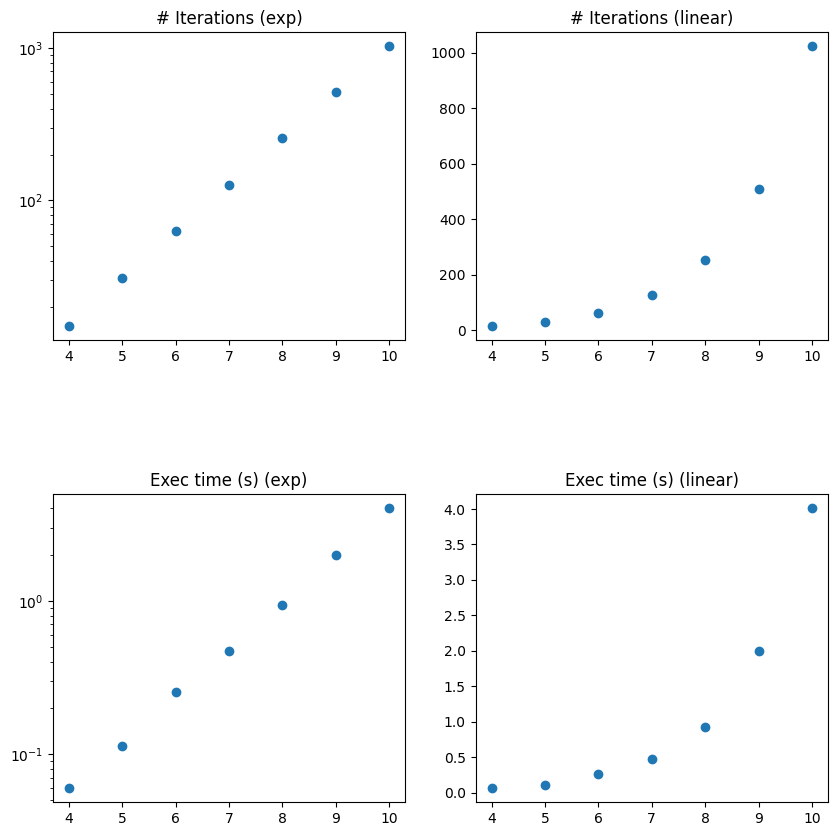

In [96]:
times_cached = {4: 0.059599999000056414, 5: 0.11189999999987776, 6: 0.25480000000015934, 7: 0.4706999990000895, 8: 0.9303000010002052, 9: 2.0010000000002037, 10: 4.009800000000041}
times = times_cached
from matplotlib import pyplot as plt

fig = plt.subplot(2, 2, 1)
fig.set_title('# Iterations (exp)')
fig.axes.set_yscale('log')
fig.scatter(iters.keys(), iters.values())

fig = plt.subplot(2, 2, 2)
fig.set_title('# Iterations (linear)')
fig.scatter(iters.keys(), iters.values())

fig = plt.subplot(2, 2, 3)
fig.set_title('Exec time (s) (exp)')
fig.axes.set_yscale('log')
fig.scatter(times.keys(), times.values())

fig = plt.subplot(2, 2, 4)
fig.set_title('Exec time (s) (linear)')
fig.scatter(times.keys(), times.values())

plt.subplots_adjust(hspace=0.5)
plt.gcf().set_size_inches((10, 10))